# Tesla Stock Predictions

Predict future stock price the high, low, open and close based on the previous days.


Implemented with a regular Neaural Network with a 2 day look back and with an LSTM based network that can have the history of the complete stock feature changes.

The data for this experiment was downloaded from Yahoo.

### Data Loading

We will use pandas to load the Tesla stock data, we will print out 5 first values in our data and we will see the quantiles for our dirrent columns as well as the standard deviation and the mean.


In [2]:
import pandas as pd

data = pd.read_csv("TSLA-2014-12-27-2019-12-27.csv")

# Let us see what our data looks like
print(data.head())
print(data.describe())

         Date        Open        High         Low       Close   Adj Close  \
0  2014-12-29  226.899994  227.910004  224.020004  225.710007  225.710007   
1  2014-12-30  223.990005  225.649994  221.399994  222.229996  222.229996   
2  2014-12-31  223.089996  225.679993  222.250000  222.410004  222.410004   
3  2015-01-02  222.869995  223.250000  213.259995  219.309998  219.309998   
4  2015-01-05  214.550003  216.500000  207.160004  210.089996  210.089996   

    Volume  
0  2802500  
1  2903200  
2  2297500  
3  4764400  
4  5368500  
              Open         High          Low        Close    Adj Close  \
count  1259.000000  1259.000000  1259.000000  1259.000000  1259.000000   
mean    268.464702   272.893026   263.884877   268.576069   268.576069   
std      55.760993    56.623837    54.890845    55.851123    55.851123   
min     142.320007   154.970001   141.050003   143.669998   143.669998   
25%     221.975006   225.139999   218.055001   220.895004   220.895004   
50%     257.350

### Visualizing

For visualizations we will visualize the line chart and the box and whiskers plot per week of the last 10 weeks, you can change the number of weeks by changing the first parameter passed to the ```visualize_box_plot``` function.

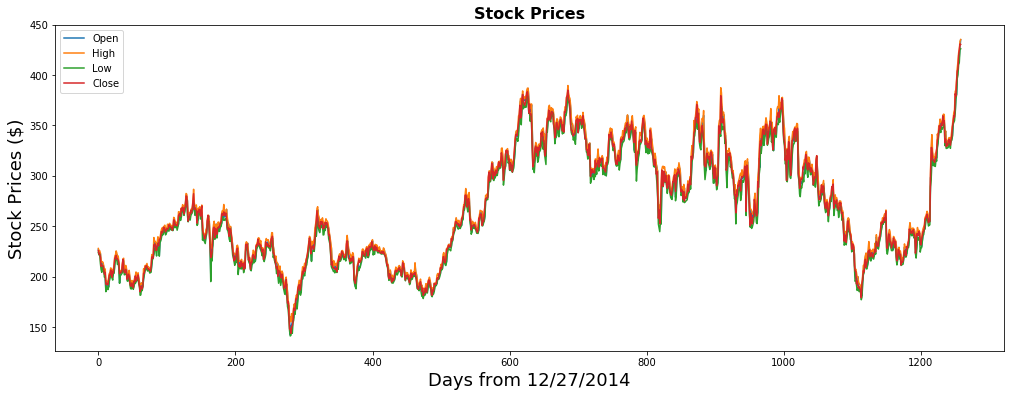

In [28]:
import matplotlib.pyplot as plt

def plot_line_graph():
    plt.rcParams['figure.figsize'] = [17, 6]
    
    plt.title('Stock Prices', size = 16, weight = 'bold')
    plt.ylabel('Stock Prices ($)', size = 18)
    plt.xlabel('Days from 12/27/2014', size = 18)

    plt.plot(data["Open"], label = "Open")
    plt.plot(data["High"], label = "High")
    plt.plot(data["Low"], label = "Low")
    plt.plot(data["Close"], label = "Close")
    plt.legend()
    plt.show()
    
plot_line_graph()

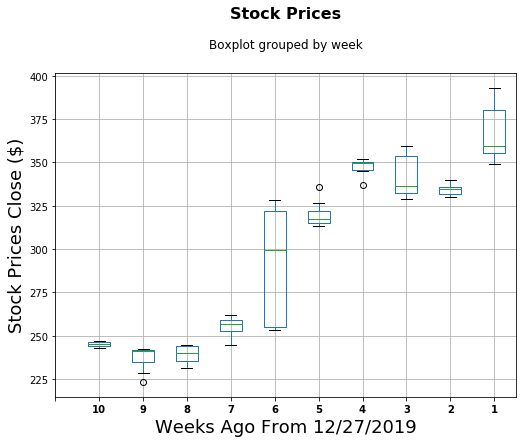

In [26]:
import numpy as np
# We should append the week

def add_week_to_the_data():
    week = []

    for i in range(len(data)):
        week.append(i / 7)

    data['week'] = week
    
add_week_to_the_data()

# We can visualize the box and whiskers plots for the last few weeks
def visualize_box_plot(weeks = 10, exclude_days = 6):
    from_index = len(data) - (weeks * 7) - exclude_days
    to_index = len(data) - exclude_days

    box_plot_data = data[:][from_index:to_index]

    plt.rcParams['figure.figsize'] = [8, 6]
    box_plot_data.boxplot(by ='week', column =['Close'], grid = True, return_type='both')

    box_plot_ax = plt.gca()
    
    weeks_ticks = ['']
    for i in range(weeks):
        weeks_ticks.append(str(weeks - i))
    
    plt.xticks(np.arange(weeks + 1), weeks_ticks, weight='bold')
    plt.title('Stock Prices', size = 16, weight = 'bold')
    plt.ylabel('Stock Prices Close ($)', size = 18)
    plt.xlabel('Weeks Ago From 12/27/2019', size = 18)

    ttl = box_plot_ax.title
    ttl.set_position([.5, 1.15])
    
visualize_box_plot()

### Torch Data Loaders

We will create the two data loaders, one for the LSTM model and one for our regular NN model with only fully connected layers.

In [8]:
import torch
import torch.nn as nn
import torch.utils.data.dataset as dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import pickle

In [11]:
scaler = MinMaxScaler()

pre_normalized = data[["Open", "High", "Low", "Close"]]

normalized_data = scaler.fit_transform(pre_normalized)

# we need to store the scaler
pickle.dump(scaler, open("saved/scaler.pkl", "wb"))

In [43]:
# We need to load the dataset code

%run datasets.py
print(open("datasets.py", "r").read())

import torch
import torch.utils.data.dataset as dataset

class LSTM_Stock_Dataset(dataset.Dataset):
    def __init__(self, lines):
        self.lines = lines

    def __len__(self):
        return len(self.lines)

    def __getitem__(self, idx):
        if not isinstance(idx, int):
            idx = idx.item()
        return torch.tensor(self.lines[idx], dtype=torch.float32)
    
class Stock_Dataset(dataset.Dataset):
    def __init__(self, lines):
        self.lines = lines

    def __len__(self):
        return len(self.lines)

    def __getitem__(self, idx):
        if not isinstance(idx, int):
            idx = idx.item()
        
        x = torch.tensor(self.lines[idx][:8], dtype=torch.float32)
        y = torch.tensor(self.lines[idx][8:], dtype=torch.float32)
        return {'x': x, 'y': y}


### Training

For training we will load our data and create the datasets, we will load 2 models from the files that define them ```regular_model.py``` and ```lstm_model.py```


### Training the regular model

In [13]:
normalized_data_for_regular = []

def append_each(to_arr, from_arr):
    for elem in from_arr:
        to_arr.append(elem)

def print_top_10(arr):
    for i in range(10):
        if i < len(arr) - 1:
            print(arr[i])

for i in range(len(normalized_data)):
    if i > 1:
        line = []
        append_each(line, normalized_data[i - 2])
        append_each(line, normalized_data[i - 1])
        append_each(line, normalized_data[i])
        normalized_data_for_regular.append(line)

In [14]:
train_len = int(0.9 * len(normalized_data_for_regular))

regular_train = normalized_data_for_regular[:train_len]
regular_test = normalized_data_for_regular[train_len:]

regular_dataset_train = Stock_Dataset(regular_train)
regular_dataset_test = Stock_Dataset(regular_test)

To see the code for the model open the file ```regular_model.py``` from this repository

In [40]:
%run regular_model.py
print(open("regular_model.py", "r").read())

from torch import nn

class RegularModel(nn.Module):
    def __init__(self):
        super(RegularModel, self).__init__()
        self.fc1 = nn.Linear(8, 10)
        self.fc2 = nn.Linear(10, 4)

    def forward(self, input):
        output = nn.functional.relu(self.fc1(input))
        output = self.fc2(output)
        return output


    def evaluate(self, model, test_loader, loss_function):
        loss = 0

        for data in test_loader:
            inputs, labels = data['x'], data['y']
            output = model.forward(inputs)
            loss += loss_function(output, labels).item()

        return loss



In [29]:
def plot(train_losses, test_losses):
    plt.plot(train_losses, label="Train")
    plt.plot(test_losses, label="Test")

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Training')
    plt.grid(True)
    plt.legend()
    plt.show()

Epoch 0: 0.0338120201408     0.0297473236782


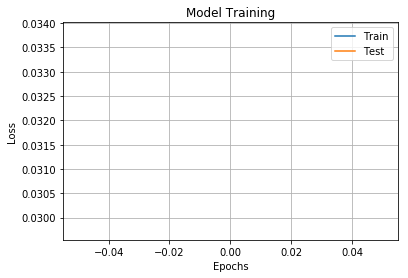

Epoch 1: 0.0123992661576     0.0221449309135


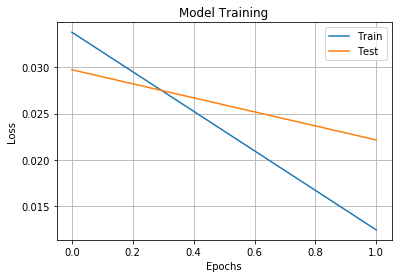

Epoch 2: 0.00785427581465     0.0158646871524


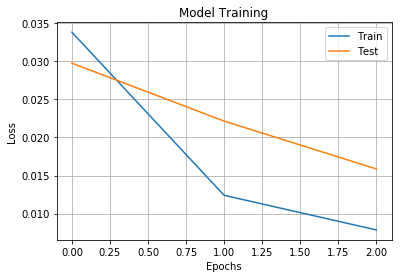

Epoch 3: 0.004895821498     0.0111495092745


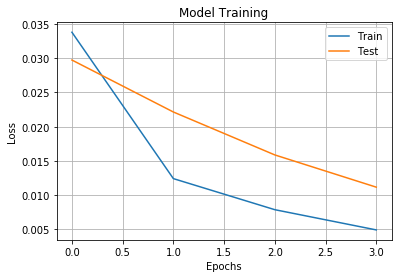

Epoch 4: 0.00308972319234     0.00773873784621


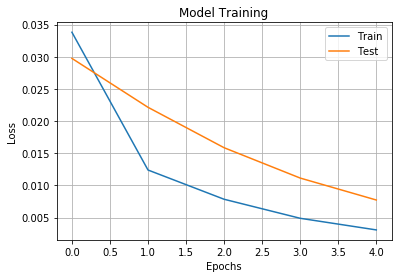

Epoch 5: 0.00202796486222     0.00543196636703


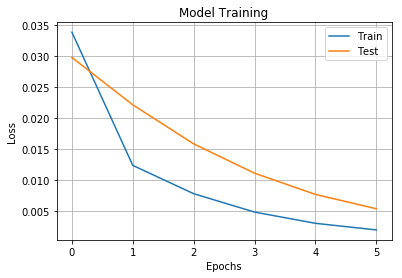

Epoch 6: 0.00142797742397     0.00394904580274


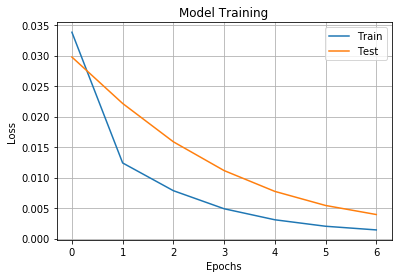

Epoch 7: 0.00109794685324     0.00301793531372


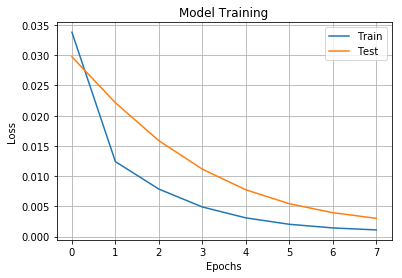

Epoch 8: 0.000918453792385     0.00243586673859


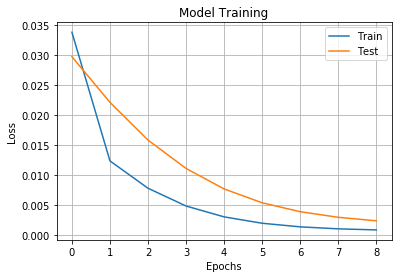

Epoch 9: 0.000820407572673     0.00206876951883


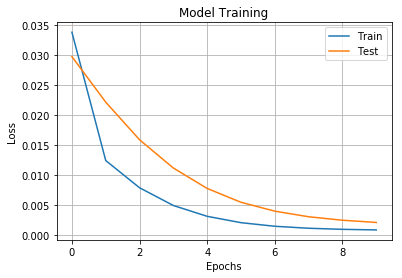

Epoch 10: 0.000766093603753     0.00183588076682


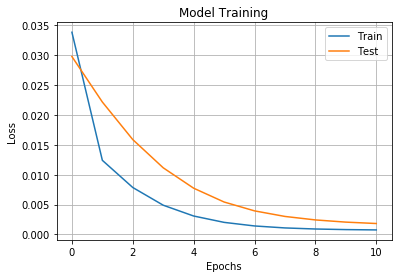

Epoch 11: 0.000735190676021     0.0016868036813


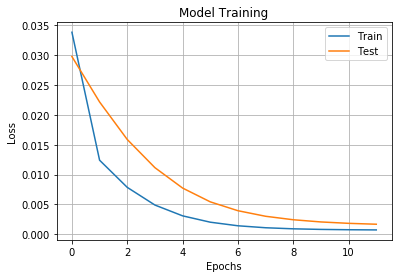

Epoch 12: 0.000716788010923     0.00158811488488


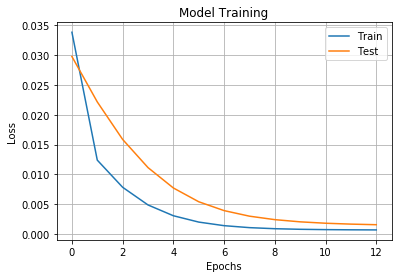

Epoch 13: 0.000705186912216     0.00152032851563


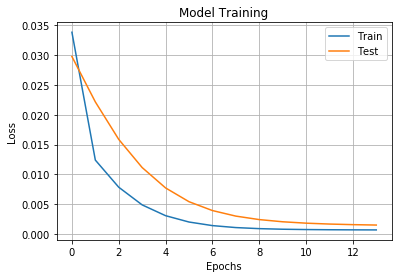

Epoch 14: 0.000697444657687     0.00147458021704


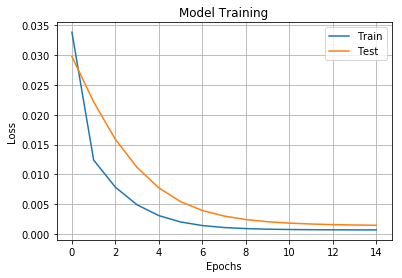

Epoch 15: 0.000691855802984     0.00144085564134


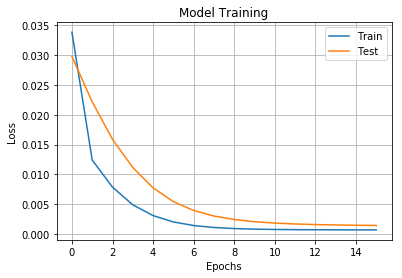

Epoch 16: 0.000687574670652     0.00141701625335


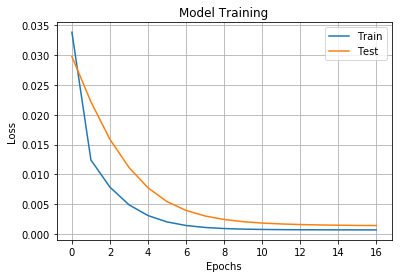

Epoch 17: 0.000684158491876     0.00139926339652


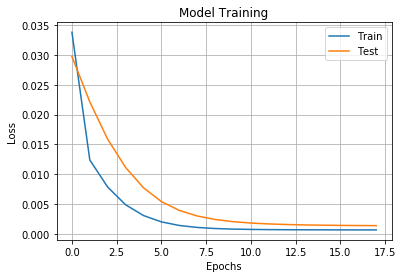

Epoch 18: 0.00068122262117     0.00138588048829


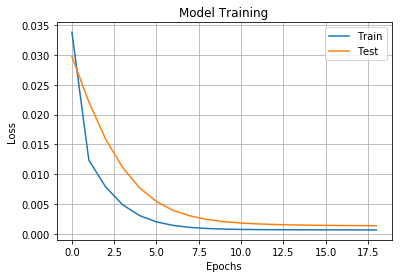

Epoch 19: 0.000678654759362     0.00137594758375


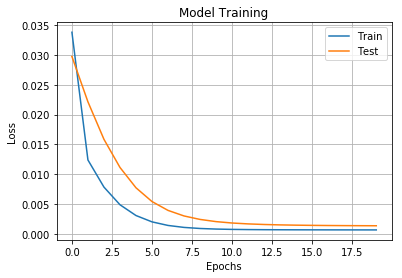

Epoch 20: 0.000676220965918     0.00136672393358


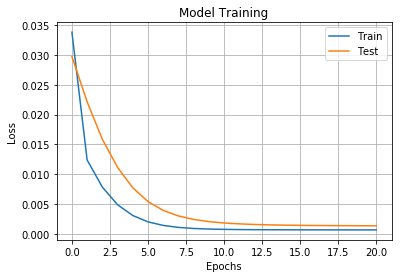

Epoch 21: 0.000673975293982     0.00135886611602


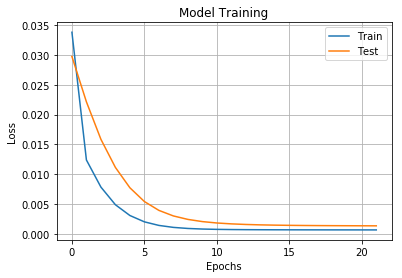

Epoch 22: 0.000671841797397     0.001352051191


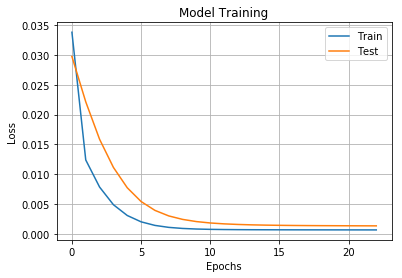

Epoch 23: 0.000669790894317     0.00134598015393


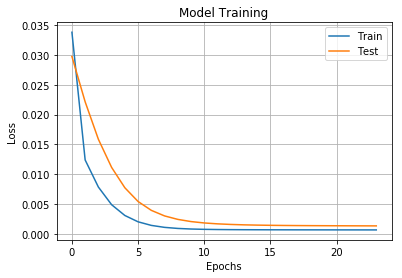

Epoch 24: 0.000667803712782     0.00134045817266


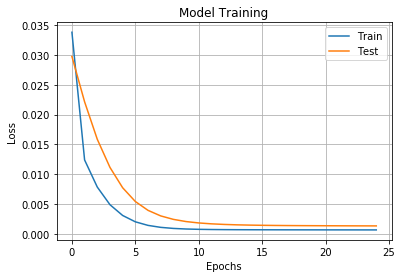

Epoch 25: 0.000665855511919     0.00133512257273


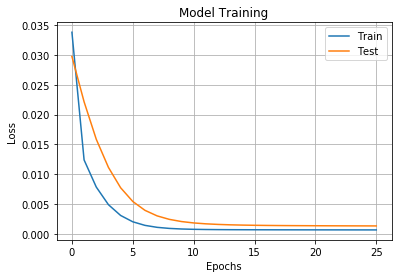

Epoch 26: 0.000663958037894     0.00133021149117


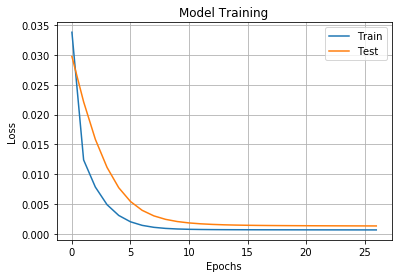

Epoch 27: 0.000662098371119     0.00132566128493


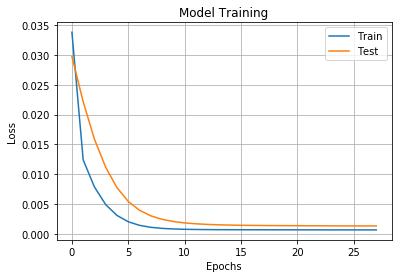

Epoch 28: 0.000660296096729     0.00132183821065


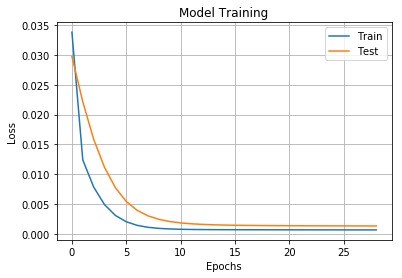

Epoch 29: 0.000658463182163     0.00131758880851


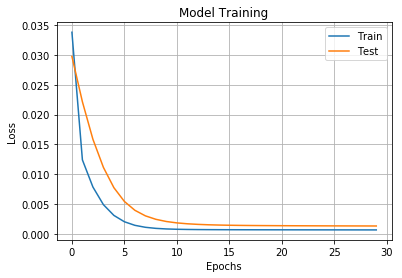

Epoch 30: 0.000656712948091     0.00131400735815


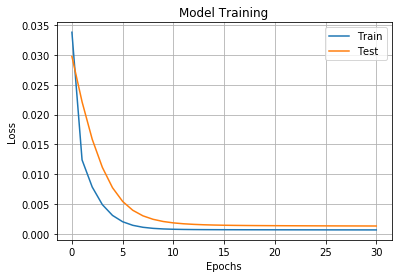

Epoch 31: 0.000654954277754     0.00131050399039


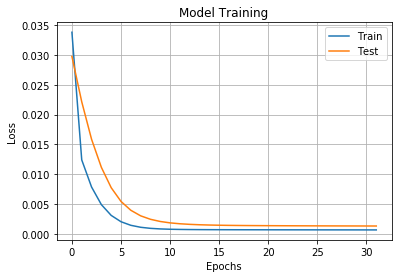

Epoch 32: 0.000653216284176     0.0013070644464


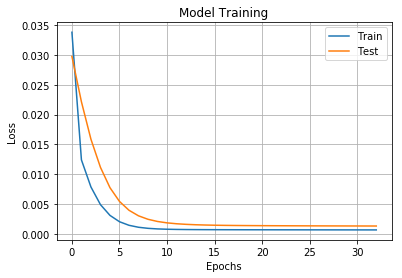

Epoch 33: 0.000651489596545     0.00130388504478


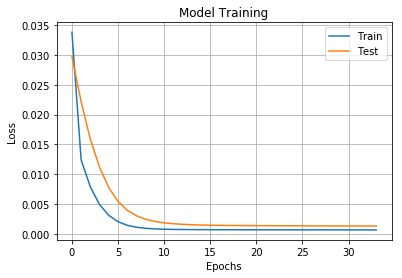

Epoch 34: 0.000649806142812     0.00130069066373


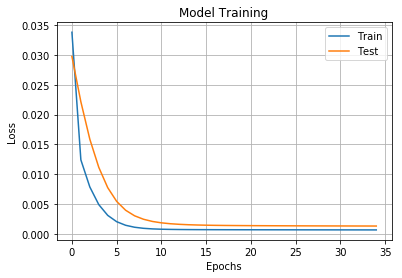

Epoch 35: 0.000648136181105     0.00129749737357


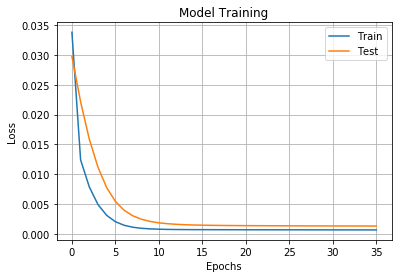

Epoch 36: 0.000646481762179     0.00129433071146


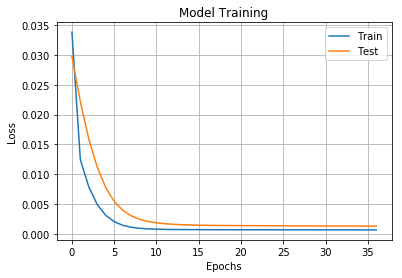

Epoch 37: 0.000644834338169     0.00129099148769


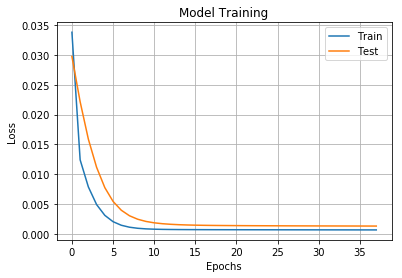

Epoch 38: 0.000643220396122     0.00128785293102


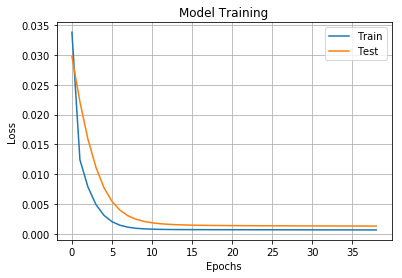

Epoch 39: 0.000641613203253     0.00128477925299


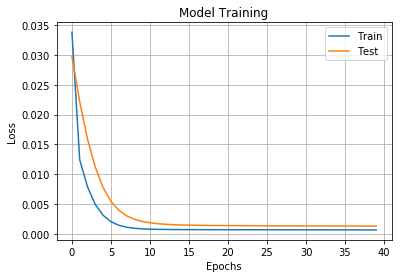

Epoch 40: 0.000639987194423     0.00128116934522


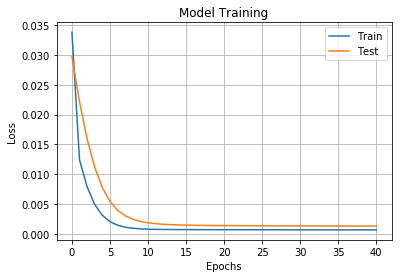

Epoch 41: 0.000638441886664     0.0012781309833


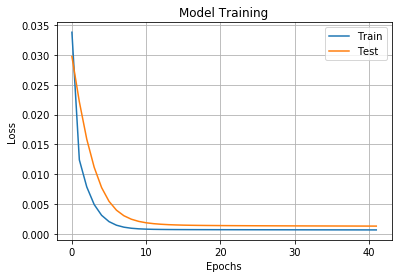

Epoch 42: 0.00063688526784     0.00127512342721


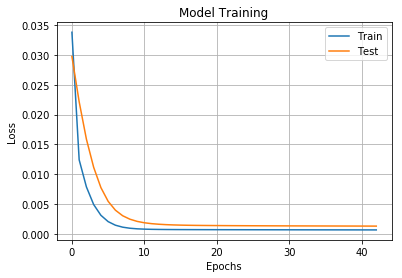

Epoch 43: 0.000635344327885     0.0012721533675


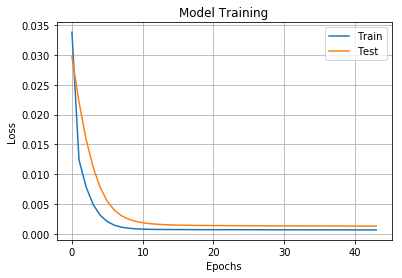

Epoch 44: 0.000633819488338     0.00126922234256


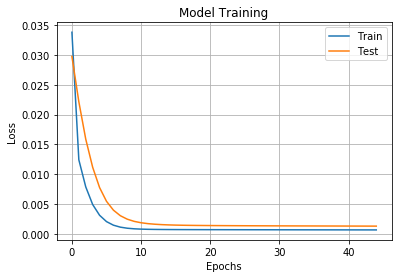

Epoch 45: 0.000632310523858     0.00126632626034


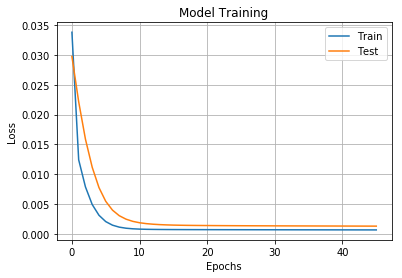

Epoch 46: 0.000630817568336     0.00126347973062


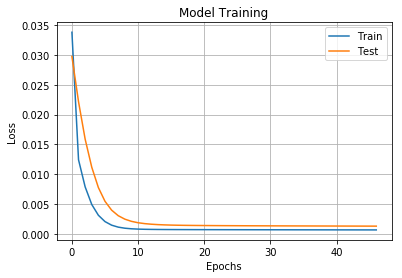

Epoch 47: 0.000629312838393     0.00126014666554


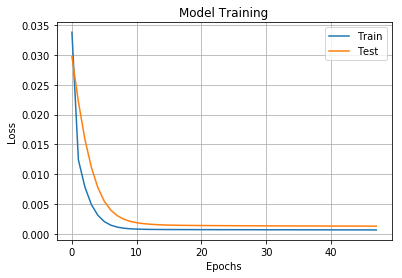

Epoch 48: 0.000627878428713     0.0012574001128


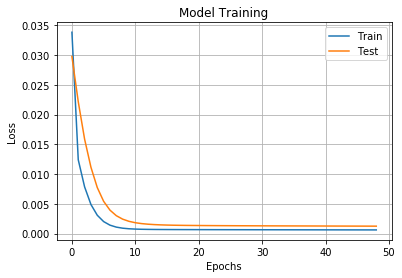

Epoch 49: 0.00062643752602     0.00125482204522


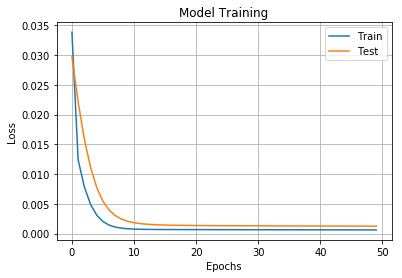

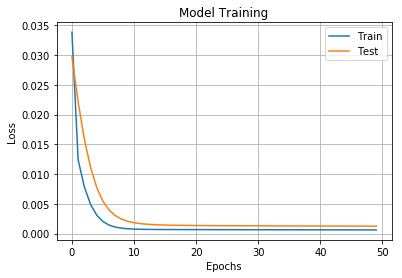

In [30]:
def train_regular_model(model, no_epochs = 50, lr = 0.001, momentum = 0.9):
    loss_function = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = 0.9)

    test_losses = []
    train_losses = []

    for epoch_i in range(no_epochs):
        model.train()
        total_train_loss = 0
        count = 0
        for idx, sample in enumerate(regular_dataset_train): # sample['input'] and sample['label']
            inputs, labels = sample['x'], sample['y']
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model.forward(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            total_train_loss = total_train_loss + loss.item()
            count = count + 1
            optimizer.step()

        test_loss = 1.0 * model.evaluate(model, regular_dataset_test, loss_function) / len(regular_dataset_test)
        train_loss = 1.0 * total_train_loss / count
        print("Epoch " + str(epoch_i) + ": " + str(train_loss) + "     " + str(test_loss))
        test_losses.append(test_loss)
        train_losses.append(train_loss)

        plot(train_losses, test_losses)

    plot(train_losses, test_losses)

model = RegularModel()
train_regular_model(model)

torch.save(model.state_dict(), "saved/regular_model.pkl")

### Training the LSTM model

In [31]:
train_len = int(0.9 * len(normalized_data))

lstm_train = normalized_data[:train_len]
lstm_test = normalized_data[train_len:]

lstm_dataset_train = LSTM_Stock_Dataset(lstm_train)
lstm_dataset_test = LSTM_Stock_Dataset(lstm_test)

To see the code for the model open the file ```lstm_model.py``` from this repository

In [41]:
%run lstm_model.py
print(open("lstm_model.py", "r").read())

from torch import nn

class LSTMModel(nn.Module):
    def __init__(self, hidden_dim):
        super(LSTMModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(4, hidden_dim, bias=True)
        self.fc1 = nn.Linear(hidden_dim, 12)
        self.fc2 = nn.Linear(12, 8)
        self.fc3 = nn.Linear(8, 4)

    def forward(self, input, hidden, cell):
        output, (hidden, cell) = self.lstm(input.view(1, 1, -1), (hidden, cell))
        output = nn.functional.relu(self.fc1(output))
        output = nn.functional.relu(self.fc2(output))
        output = self.fc3(output)
        
        return output, (hidden, cell)
    
    def init_hidden(self):
        hidden = torch.zeros(1, 1, self.hidden_dim)
        cell = torch.zeros(1, 1, self.hidden_dim)

        return (hidden, cell)

    def evaluate(self, model, test_loader, hidden, cell, loss_function):
        loss = 0
        
        for i in range(len(test_loader) - 1):
            inputs = 

Epoch 0: 0.0359435147273     0.040698576672


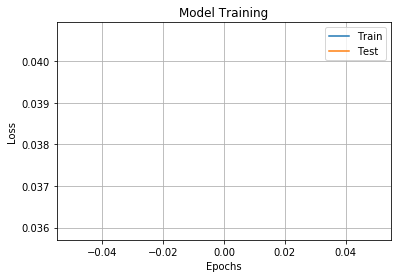

Epoch 1: 0.0235575083793     0.0404461144339


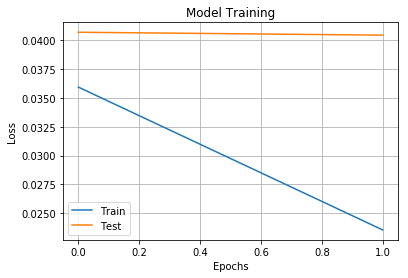

Epoch 2: 0.0233868761755     0.0401420710646


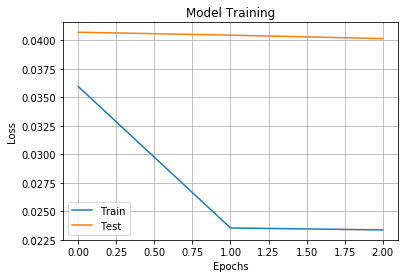

Epoch 3: 0.0231448431749     0.0397834886629


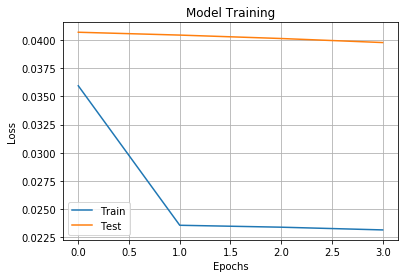

Epoch 4: 0.0228260791996     0.0393617320769


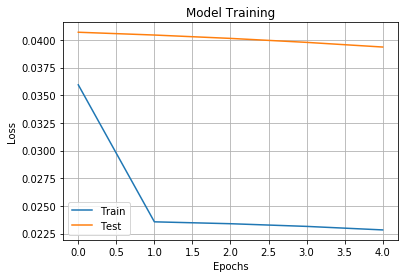

Epoch 5: 0.0224103562313     0.0388554969579


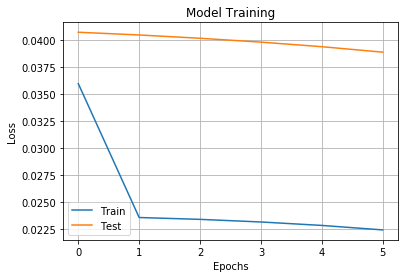

Epoch 6: 0.021879446929     0.0382251400538


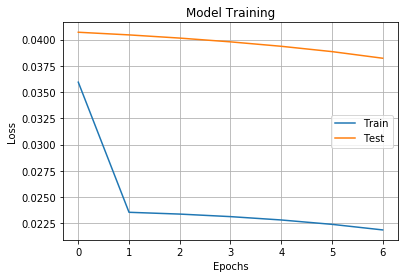

Epoch 7: 0.0212024110666     0.0374333955478


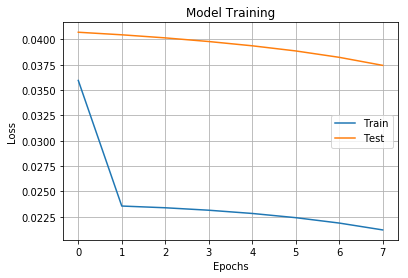

Epoch 8: 0.0203331148944     0.0364257003069


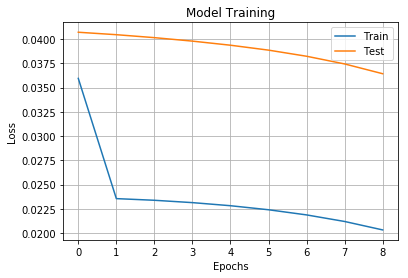

Epoch 9: 0.0192169362674     0.0351350765713


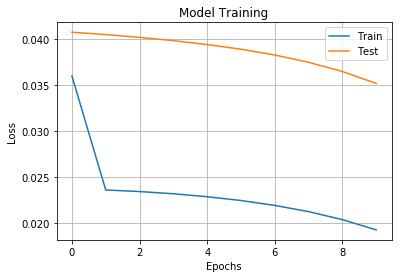

Epoch 10: 0.0177919545203     0.0334793241546


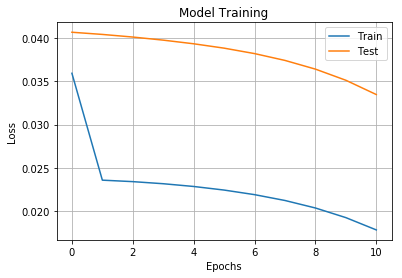

Epoch 11: 0.0160008397465     0.0313781536771


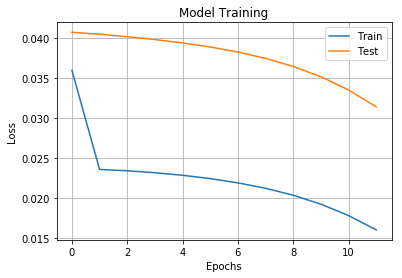

Epoch 12: 0.0138404317894     0.028776254572


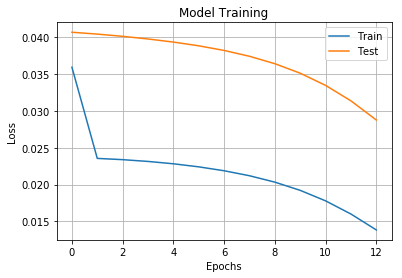

Epoch 13: 0.0113748718337     0.025694739505


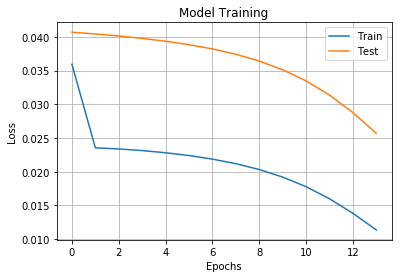

Epoch 14: 0.00884905874571     0.0223771387701


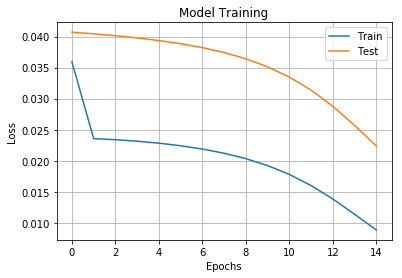

Epoch 15: 0.0066180254164     0.0190926848914


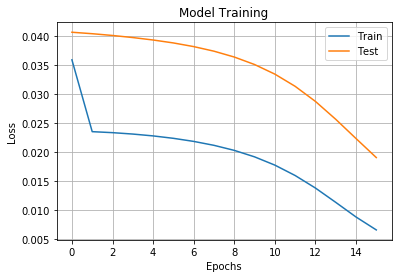

Epoch 16: 0.00487077445791     0.0161269865809


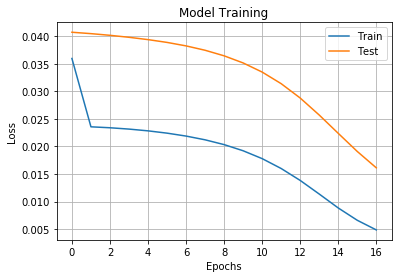

Epoch 17: 0.00367075959791     0.0135478535157


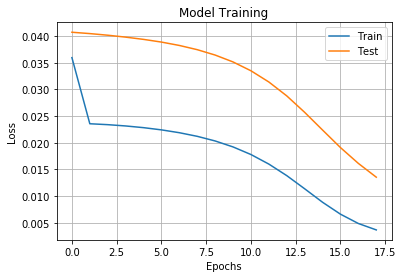

Epoch 18: 0.00287784049259     0.0114024694203


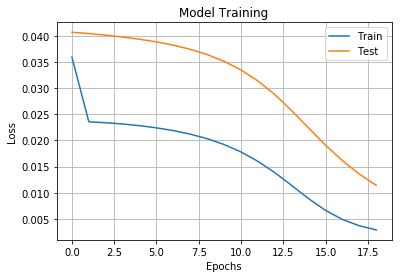

Epoch 19: 0.00236849491951     0.00969125813185


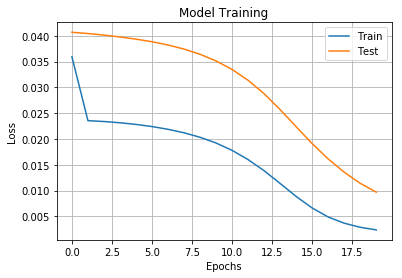

Epoch 20: 0.00204147779785     0.00839230795126


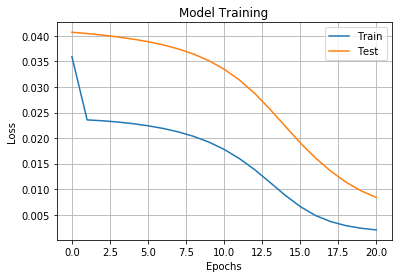

Epoch 21: 0.00183304709481     0.00743234844811


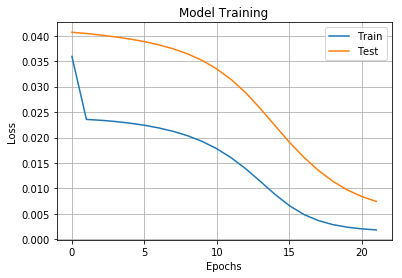

Epoch 22: 0.00169410018958     0.00673102057946


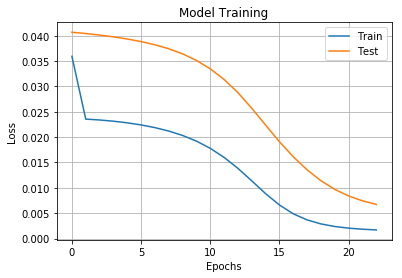

Epoch 23: 0.00159901983619     0.00622114686359


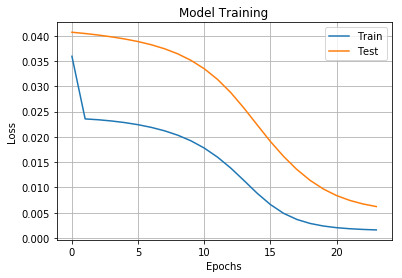

Epoch 24: 0.0015317442848     0.00584808512317


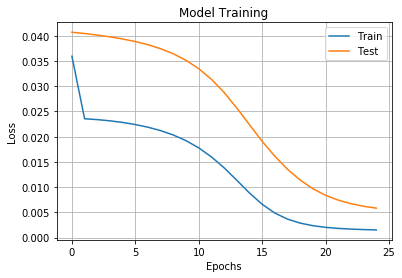

Epoch 25: 0.00148146237184     0.00555789382189


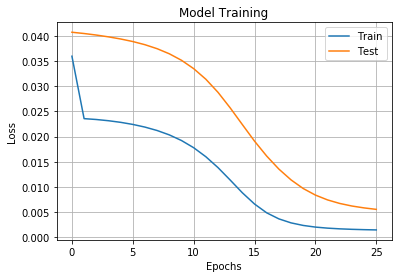

Epoch 26: 0.00144107424789     0.00534269264941


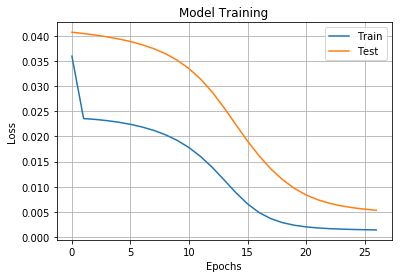

Epoch 27: 0.00140859542566     0.00517812449839


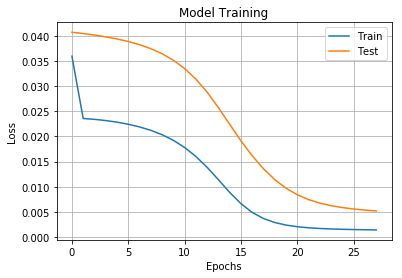

Epoch 28: 0.00138157700425     0.00504757238274


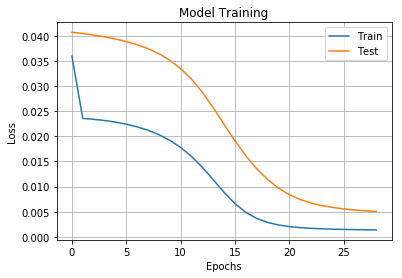

Epoch 29: 0.00135739166003     0.00493961457036


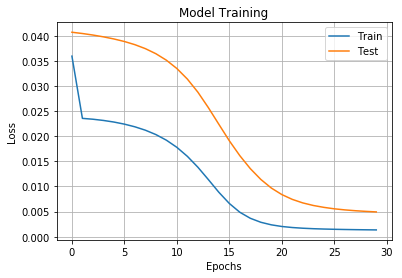

Epoch 30: 0.00133559293622     0.00485088127793


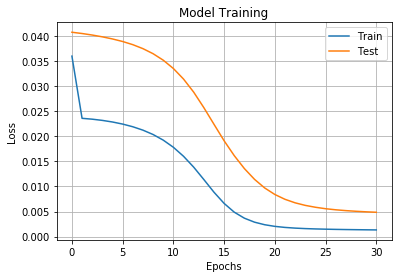

Epoch 31: 0.00131695082906     0.00476913097013


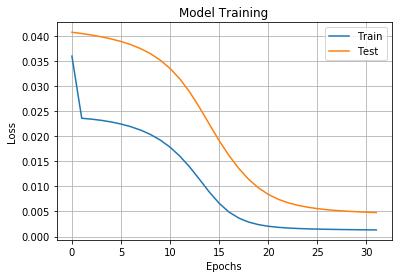

Epoch 32: 0.00129888068256     0.00469754549053


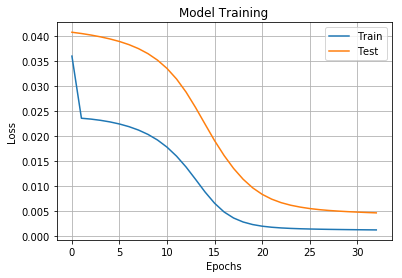

Epoch 33: 0.00128240044967     0.0046349219878


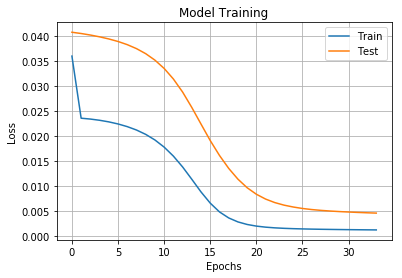

Epoch 34: 0.00126712723392     0.004574498828


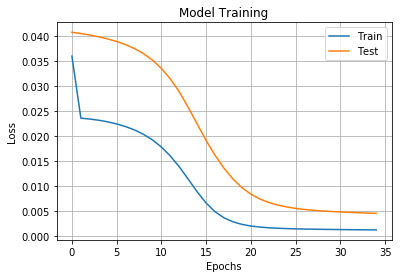

Epoch 35: 0.00125230715514     0.00452129334071


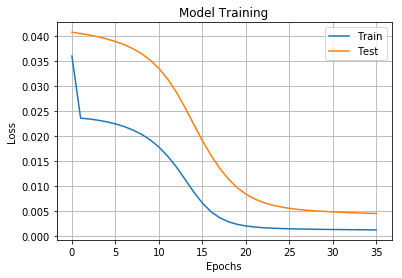

Epoch 36: 0.00123852120621     0.00447081375118


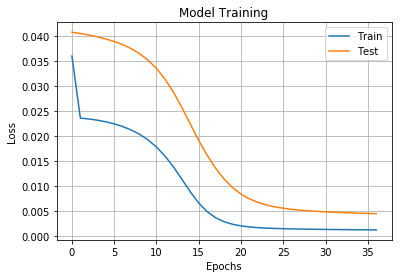

Epoch 37: 0.00122637330696     0.00441218859724


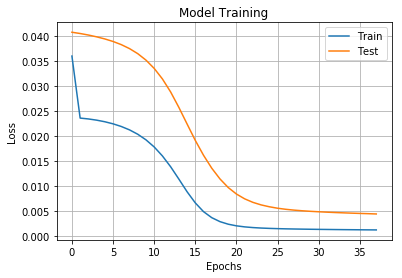

Epoch 38: 0.00121385234446     0.0043586447831


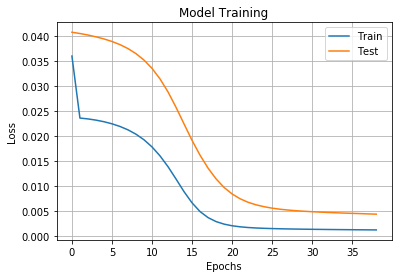

Epoch 39: 0.00120188850239     0.0043101476411


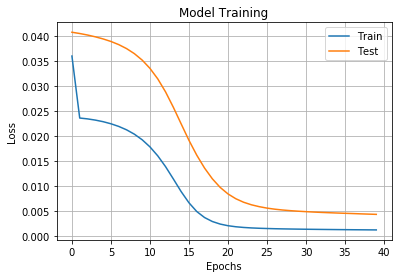

Epoch 40: 0.00119061645704     0.00426418719631


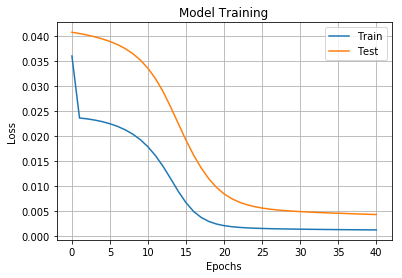

Epoch 41: 0.0011797116616     0.00422208018275


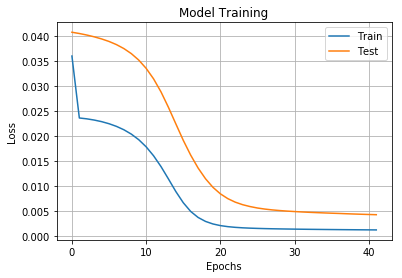

Epoch 42: 0.00116951284646     0.00418073079721


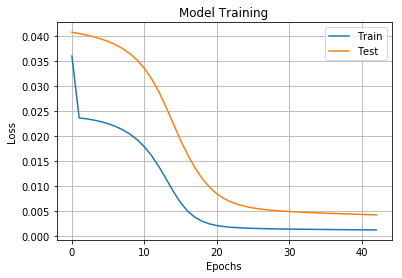

Epoch 43: 0.00116005726407     0.00413707267146


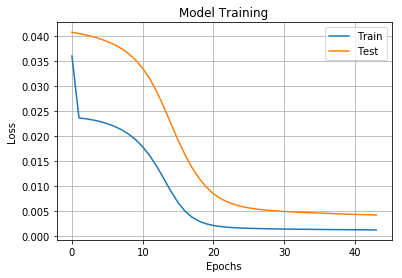

Epoch 44: 0.0011504604222     0.00409571889637


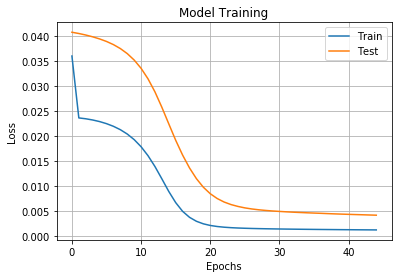

Epoch 45: 0.00114133658376     0.00405971491754


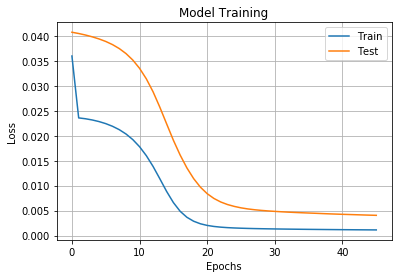

Epoch 46: 0.00113250260181     0.00402492573837


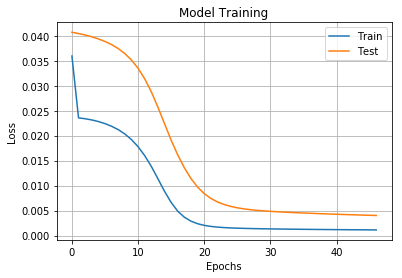

Epoch 47: 0.00112398413792     0.00399113731358


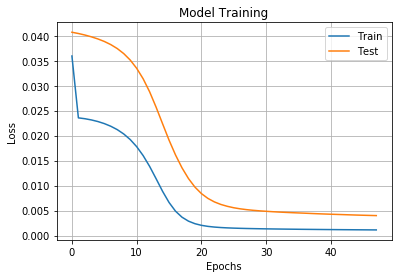

Epoch 48: 0.00111573358116     0.00395834172954


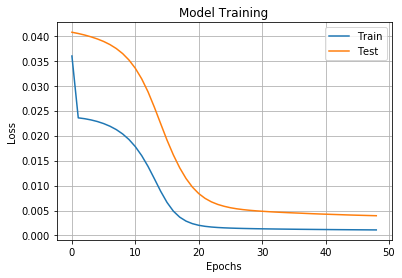

Epoch 49: 0.00110764536534     0.00392803203711


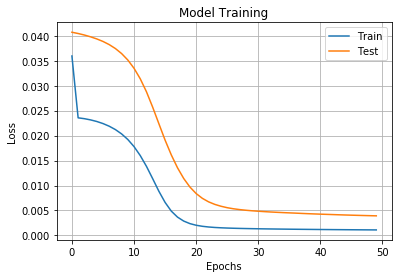

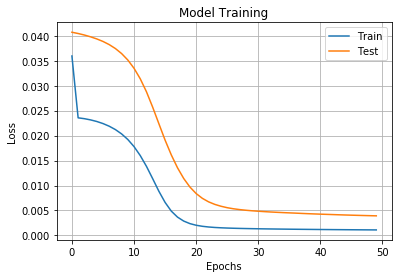

In [33]:
def train_lstm_model(lstm_model, no_epochs = 50, lr = 0.0008, momentum = 0.9):
    lstm_loss_function = nn.MSELoss()
    lstm_optimizer = torch.optim.SGD(lstm_model.parameters(), lr = lr, momentum = momentum)

    lstm_test_losses = []
    lstm_train_losses = []

    for epoch_i in range(no_epochs):
        (hidden, cell) = lstm_model.init_hidden()

        lstm_model.train()

        total_train_loss = 0
        count = 0
        for i in range(len(lstm_dataset_train) - 1):
            inputs = lstm_dataset_train[i]
            labels = lstm_dataset_train[i + 1]

            lstm_optimizer.zero_grad()

            # forward + backward + optimize
            outputs, (hidden, cell) = lstm_model.forward(inputs, hidden, cell)

            loss = lstm_loss_function(outputs, labels)
            loss.backward(retain_graph=True)
            total_train_loss = total_train_loss + loss.item()
            count = count + 1
            lstm_optimizer.step()


        test_loss = 1.0 * lstm_model.evaluate(lstm_model, lstm_dataset_test, hidden, cell, lstm_loss_function) / (len(lstm_dataset_test) - 1)
        train_loss = 1.0 * total_train_loss / (len(lstm_dataset_train) - 1) # total_train_loss / count
        print("Epoch " + str(epoch_i) + ": " + str(train_loss) + "     " + str(test_loss))
        lstm_test_losses.append(test_loss)
        lstm_train_losses.append(train_loss)

        plot(lstm_train_losses, lstm_test_losses)

    plot(lstm_train_losses, lstm_test_losses)

lstm_model = LSTMModel(8)
train_lstm_model(lstm_model, 50)
torch.save(lstm_model.state_dict(), "saved/lstm_model.pkl")

### Inference

Loading the model and running the inference is done in the ```Tesla Stock Predictions Inference.ipynb``` notebook file.